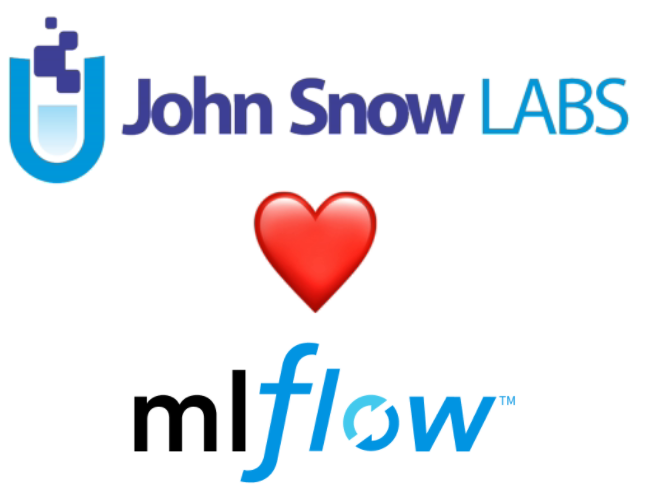

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/logging/MLFLow_NER_template.ipynb)

In this notebook we are going to explore how to train an Entity Resolver model and track the experiment in MLFlow.

[MLFlow](https://www.mlflow.org/) MLflow is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry. MLFlow supports natively Spark MLLib and Spark NLP Pipelines, among many other formats (flavours), and runs transparently in Databricks.

# Imports

In [0]:
import json
import os
import time
import mlflow
import pandas as pd
import datetime

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.training import *
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from sparknlp.training import CoNLL
from pyspark.sql import SparkSession
from sparknlp_jsl.annotator import *

### Check sparknlp and mlflow versions

In [0]:
sparknlp.version()

Out[3]: '3.4.0'

In [0]:
mlflow.__version__

Out[4]: '1.21.0'

## Checking the Spark Session is alive

In [0]:
spark

Out[5]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

# Preparing the EntityResolverApproach() model training

## Data preparation

In [0]:
!mkdir /dbfs/temp/ERApproach

In [0]:
!ls /dbfs/temp/ERApproach

AskAPatient.fold-0.test.txt AskAPatient.fold-0.validation.txt
AskAPatient.fold-0.train.txt

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/AskAPatient.fold-0.test.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/AskAPatient.fold-0.train.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/AskAPatient.fold-0.validation.txt

dbutils.fs.cp("file:/databricks/driver/AskAPatient.fold-0.test.txt", "dbfs:/temp/ERApproach")
dbutils.fs.cp("file:/databricks/driver/AskAPatient.fold-0.train.txt", "dbfs:/temp/ERApproach")
dbutils.fs.cp("file:/databricks/driver/AskAPatient.fold-0.validation.txt", "dbfs:/temp/ERApproach")

Out[23]: True

In [0]:
cols = ["conceptId","_term","term"]

aap_tr = pd.read_csv("/dbfs/temp/ERApproach/AskAPatient.fold-0.train.txt",sep="\t",encoding="ISO-8859-1",header=None)
aap_tr.columns = cols
aap_tr["conceptId"] = aap_tr.conceptId.apply(str)

aap_ts = pd.read_csv("/dbfs/temp/ERApproach/AskAPatient.fold-0.test.txt",sep="\t",header=None)
aap_ts.columns = cols
aap_ts["conceptId"] = aap_ts.conceptId.apply(str)

aap_vl = pd.read_csv("/dbfs/temp/ERApproach/AskAPatient.fold-0.validation.txt",sep="\t",header=None)
aap_vl.columns = cols
aap_vl["conceptId"] = aap_vl.conceptId.apply(str)

In [0]:
aap_vl.head()

Out[10]:

,conceptId,_term,term
0,267032009,Tired all the time,persisten feeling of tiredness
1,22298006,Myocardial infarction,HEART ATTACK
2,3877011000036101,Lipitor,LIPITOR
3,415690000,Sweating,sweated
4,248491001,Swollen knee,swelling at knee


## Creating dataframes

In [0]:
aap_train_sdf = spark.createDataFrame(aap_tr)
aap_test_sdf = spark.createDataFrame(aap_ts)
aap_val_sdf = spark.createDataFrame(aap_vl)

In [0]:
aap_train_sdf.show()

+----------------+--------------------+--------------------+
 conceptId| _term| term|
+----------------+--------------------+--------------------+
 108367008|Dislocation of joint|Dislocation of joint|
3384011000036100| Arthrotec| Arthrotec|
 166717003|Serum creatinine ...|Serum creatinine ...|
3877011000036101| Lipitor| Lipitor|
 402234004| Foot eczema| Foot eczema|
 404640003| Dizziness| Dizziness|
 271681002| Stomach ache| Stomach ache|
 76948002| Severe pain| Severe pain|
 36031001| Burning feet| Burning feet|
 76948002| Severe pain| Severe pain|
 42399005| Renal failure| Renal failure|
 288227007|Myalgia/myositis ...|Myalgia/myositis ...|
 419723007| Mentally dull| Mentally dull|
 248490000| Bloating symptom| Bloating symptom|
 22253000| Pain| Pain|
 162076009|Excessive upper g...|Excessive upper g...|
 247592009|Poor short-term m...|Poor short-term m...|
 62507009| Pins and needles| Pins and needles|
3877011000036101| Lipitor| Lipitor|
 62507009| Pins and needles| Pins and needles|
+----------------+--------------------+--------------------+
only showing top 20 rows

## Defining the experiment params

In [0]:
train_params = {
  'model_name': 'snomed_askapatient_25_1000', 
  'neighbours': 25, 
  'threshold': 1000, 
  'distance': 'EUCLIDIAN', 
  'case_sensitive': False,
}

dataset_params = {
  'train_df_url': 'https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/AskAPatient.fold-0.train.txt',
  'test_df_url': 'https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/AskAPatient.fold-0.test.txt',
  'val_df_url': 'https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/AskAPatient.fold-0.validation.txt'
  }

output_params = {
  'training_time': None, # TO BE SET AFTER TRAINING
  'inference_time': None, # TO BE SET AFTER INFERENCE
  'training_date': datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
}

## Register the experiment.
You can also do this in the Experiment Widget on the top right section (Comments - Experiment - Revision History)

In [0]:
EXPERIMENT_PATH = '/Users/juan@johnsnowlabs.com/' + train_params['model_name']
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_PATH)

In [0]:
EXPERIMENT_ID

Out[38]: '260956993499464'

## Logging datasets and params into the experiment

In [0]:
for k,v in train_params.items():
  mlflow.log_param(k, v)

In [0]:
for k,v in dataset_params.items():
  mlflow.log_param(k, v)

In [0]:
mlflow.log_artifact("/dbfs/temp/ERApproach/AskAPatient.fold-0.train.txt")
mlflow.log_artifact("/dbfs/temp/ERApproach/AskAPatient.fold-0.test.txt")
mlflow.log_artifact("/dbfs/temp/ERApproach/AskAPatient.fold-0.validation.txt")

## Training

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("_term")\
    .setOutputCol("sentence")

bert_embeddings = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["sentence"])\
    .setOutputCol("bert_embeddings")


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]

In [0]:
bertExtractor = SentenceEntityResolverApproach()\
  .setNeighbours(train_params['neighbours'])\
  .setThreshold(train_params['threshold'])\
  .setDistanceFunction(train_params['distance'])\
  .setCaseSensitive(train_params['case_sensitive'])\
  .setInputCols("bert_embeddings")\
  .setNormalizedCol("_term")\
  .setLabelCol("conceptId")\
  .setOutputCol('snomed_code')

In [0]:
snomed_training_pipeline = Pipeline(stages = [
    documentAssembler,
    bert_embeddings,
    bertExtractor])
start = time.time()
snomed_training_model = snomed_training_pipeline.fit(aap_train_sdf)
end = time.time()
print(f"Elapsed time: {str(end-start)}")
output_params['training_time'] = (end-start)

Elapsed time: 160.39561200141907

In [0]:
! cd /databricks/driver/ && mkdir models

mkdir: cannot create directory ‘models’: File exists

## Saving the model as an artifact

In [0]:
! cd /databricks/driver/ && mkdir models

In [0]:
snomed_training_model.stages[-1].write().overwrite().save(f"/dbfs/temp/ERApproach/{train_params['model_name']}")

In [0]:
mlflow.log_artifacts(f"/dbfs/temp/ERApproach/{train_params['model_name']}")

## Inferring

In [0]:
aap_train_pred = snomed_training_model.transform(aap_train_sdf)
aap_test_pred = snomed_training_model.transform(aap_test_sdf)
aap_val_pred = snomed_training_model.transform(aap_val_sdf)

In [0]:
start = time.time()
aap_test_pred.write.mode('overwrite').parquet('/dbfs/temp/ERApproach/test_inference')
end = time.time()
print(f"Elapsed time: {str(end-start)}")
output_params['inference_time'] = (end-start)

Elapsed time: 3.0053229331970215

In [0]:
aap_test_pred_pd = aap_test_pred.selectExpr("conceptId","term","_term","snomed_code[0].result","snomed_code[0].metadata.resolved_text","snomed_code[0].metadata.all_k_resolutions").toPandas()
aap_test_pred_pd

Out[69]:

,conceptId,term,_term,snomed_code[0].result,snomed_code[0].metadata[resolved_text],snomed_code[0].metadata[all_k_resolutions]
0,108367008,dislocating,Dislocation of joint,108367008,Dislocation of joint,Dislocation of joint:::Joint injury:::Disorder...
1,3384011000036100,Arthrotec,Arthrotec,3384011000036100,Arthrotec,Arthrotec
2,166717003,elevated creatine,Serum creatinine raised,166717003,Serum creatinine raised,Serum creatinine raised:::Increased creatine k...
3,3877011000036101,Lipitor,Lipitor,3877011000036101,Lipitor,Lipitor
4,402234004,Eczema on feet,Foot eczema,402234004,Foot eczema,Foot eczema:::Eczema:::Hand eczema:::Tendoniti...
...,...,...,...,...,...,...
862,361137007,severe irregular heartbeat,Irregular heart beat,361137007,Irregular heart beat,Irregular heart beat:::Irregular heart rate:::...
863,3877011000036101,Lipitor,Lipitor,3877011000036101,Lipitor,Lipitor
864,248262001,sleepy all or most sf the time,Always sleepy,248262001,Always sleepy,Always sleepy:::Constantly crying:::Constant pain
865,3384011000036100,Arthrotec,Arthrotec,3384011000036100,Arthrotec,Arthrotec


In [0]:
aap_test_pred_pd.to_csv(f"/dbfs/temp/ERApproach/select_results.csv", index=None)

In [0]:
mlflow.log_artifact(f"/dbfs/temp/ERApproach/select_results.csv")

## Let's add the output params (training, inference times, etc)

In [0]:
for k,v in output_params.items():
  mlflow.log_param(k, v)

## Add your metrics here!
You can calculate performance metrics using results of different runs, and add them to the model using the following syntax:

In [0]:
mlflow.log_metric('F1', 0.8) # This is just an example!
mlflow.log_metric('Recall', 0.86) # This is just an example!
mlflow.log_metric('Precision', 0.78) # This is just an example!

# Check your experiment in Databricks MLFlow UI!
To do that, go to top right corner (Comments - Experiment - Revision History), and click on Experiment.
THen, click on the icon next to your latest run to open MLFlow UI.

Let's see some screenshots of the experiment!

### 1) The main MLFlow screen, showing sections (params, metrics, etc) and artifacts logged (datasets, inference results, model, etc)

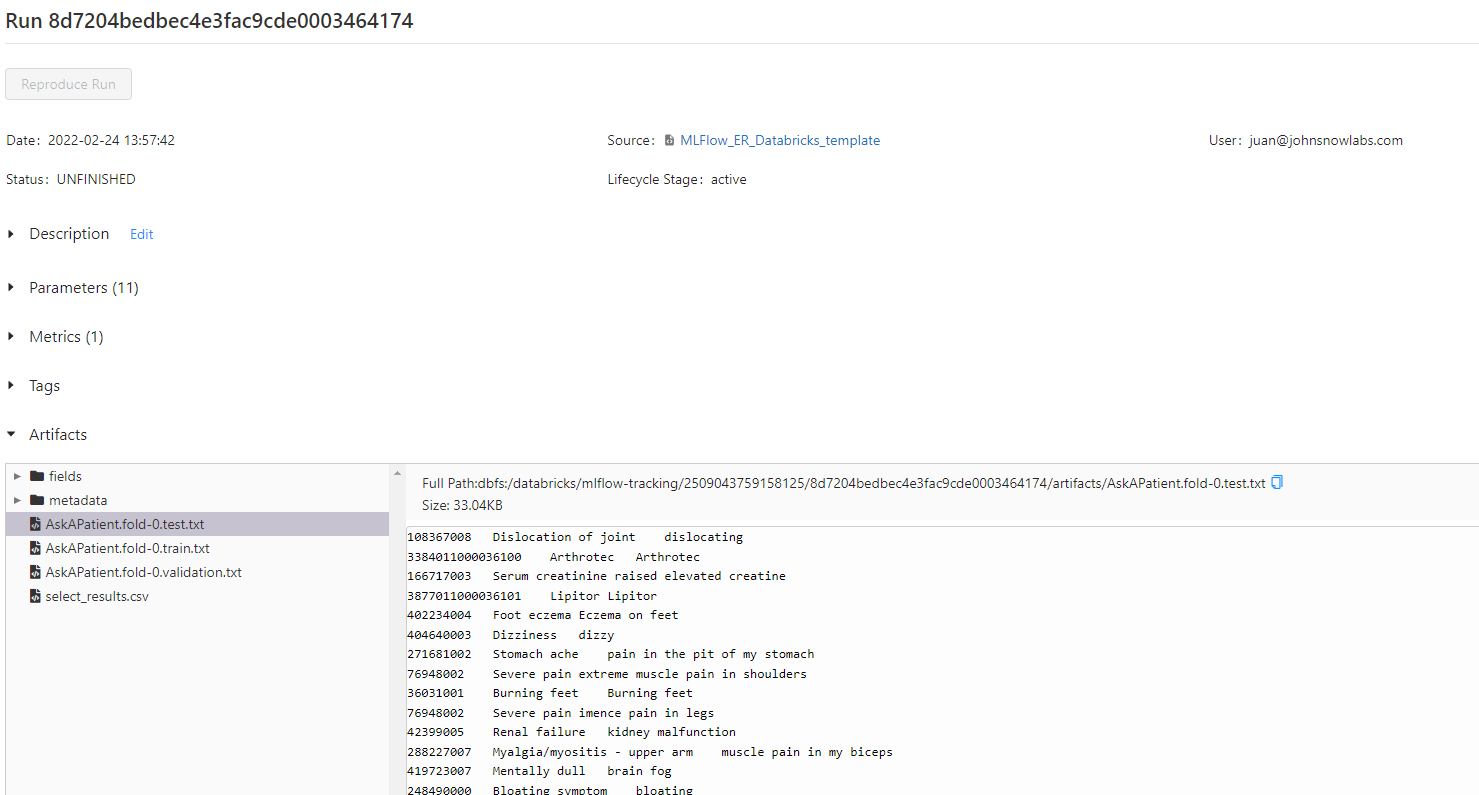

### 2) If you click on any metric, you can zoom get into the Metric Viewer, that allows you to visualize and compare your metrics

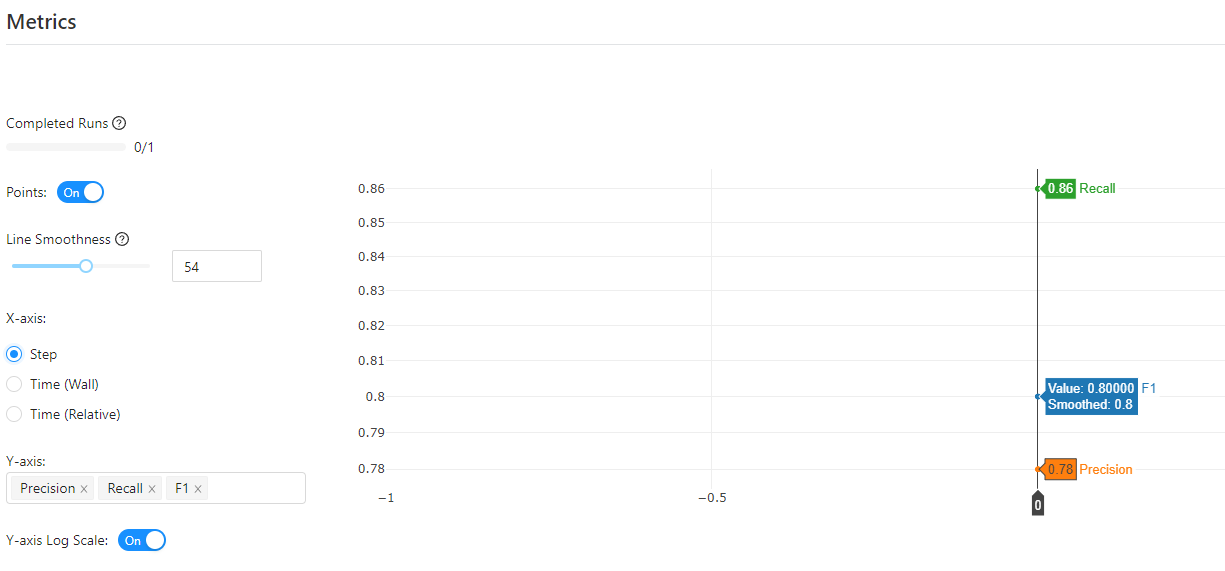

### 3) You can click on the sections or the artifacts to view them

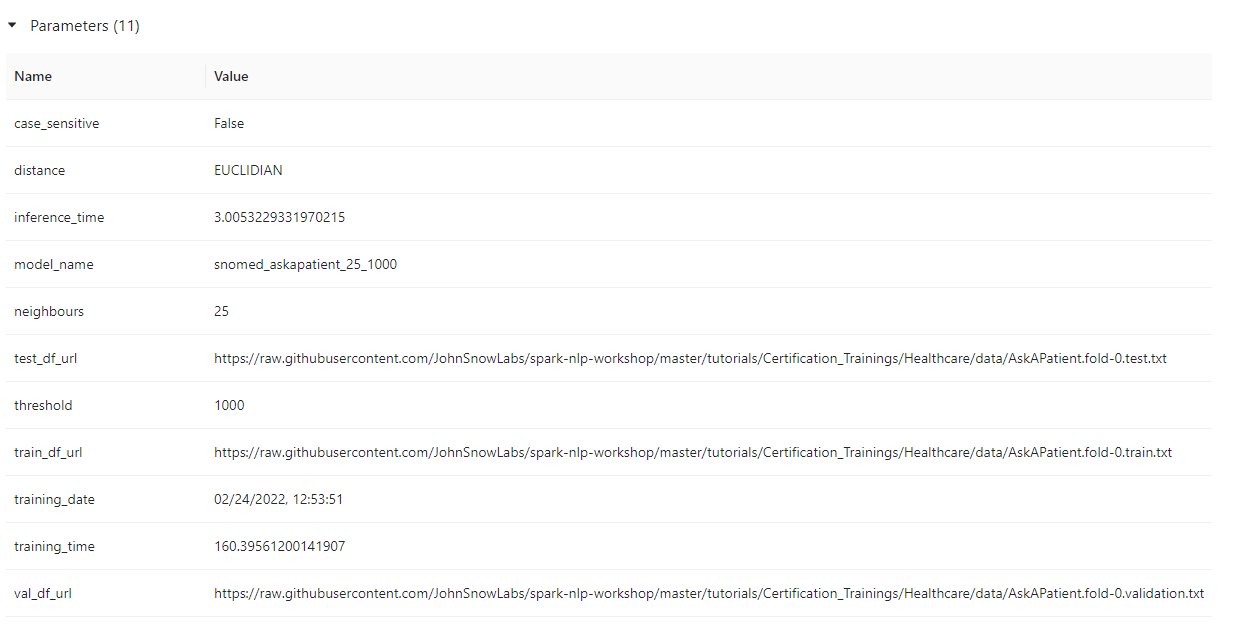

In [0]:
For artifacts, you check the contents and even download them from the interface. This experiment will be accessible in your Experiment Screen in DB, 
so you can come any time and download the artifacts, without needing to start the notebook or check the file system.

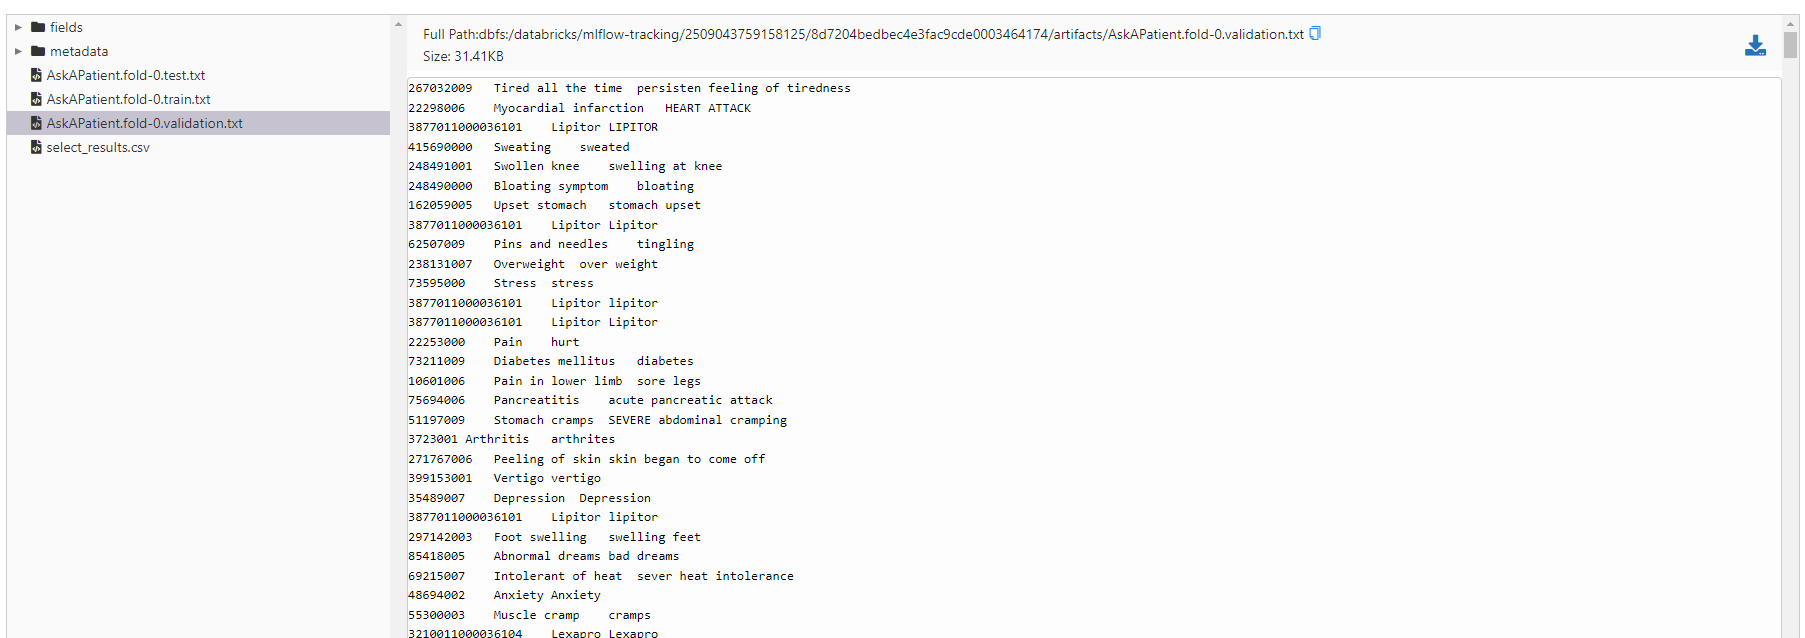